# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [1]:
!pip install plotly

In [61]:
import pandas as pd
import numpy as np
import random

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score as r2


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use("seaborn-ticks")
plt.rcParams['figure.figsize'] = (6 , 4)
matplotlib.rcParams.update({"font.size" : 14})

In [62]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [63]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    '''
    
    '''
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
   

### 1) Загрузка датасета

In [64]:
DataSet_train = "C:/Users/sergey/OneDrive/Рабочий стол/Data Science1/Курсовой проект/train.csv"
DataSet_test = "C:/Users/sergey/OneDrive/Рабочий стол/Data Science1/Курсовой проект/test.csv"

In [65]:
train_df = pd.read_csv(DataSet_train, index_col = "Id")
train_df.sort_values(by = "Id")
test_df = pd.read_csv(DataSet_test, index_col = "Id")
test_df.sort_values(by = "Id")

train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [66]:
train_df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

**Описание датасета:**  
**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры  

### 2) Получение информации о данных

In [67]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [68]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


### обзор не числовых переменных 

In [69]:
df_object_features = train_df.describe(include='object')
df_object_features.head()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [70]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [71]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [72]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [73]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

In [74]:
train_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,nan,0,11,1,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,2.00,50.40,30.48,5.00,6,5.00,1968,0.14,1,1,46,7960,6,350.00,3,11,1,"196,684.32"
6159,18,1.00,41.52,20.54,9.00,13,13.00,2000,0.00,1,1,30,5562,0,nan,0,5,0,"189,050.29"
5123,27,1.00,47.94,nan,1.00,12,16.00,2015,0.07,1,1,2,629,1,nan,0,0,0,"159,143.81"


### Обработка пропусков

In [75]:
len(train_df)-train_df.count()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [76]:
round(train_df.isna().mean() * 100, 2)

DistrictId       0.00
Rooms            0.00
Square           0.00
LifeSquare      21.13
KitchenSquare    0.00
Floor            0.00
HouseFloor       0.00
HouseYear        0.00
Ecology_1        0.00
Ecology_2        0.00
Ecology_3        0.00
Social_1         0.00
Social_2         0.00
Social_3         0.00
Healthcare_1    47.98
Helthcare_2      0.00
Shops_1          0.00
Shops_2          0.00
Price            0.00
dtype: float64

### Найдем среднюю зависимость Square от LifeSquare
Пробовал делать амену на медиано, эперечиским путем мой вариан окаался выигрышнее.

In [77]:
features_Square_LifeSquare = (train_df['Square'] - train_df['LifeSquare']  )
features_Square_LifeSquare

Id
14038   18.54
15053   25.63
4765    15.75
5809     0.62
10783   15.87
         ... 
77      19.93
6159    20.98
5123      nan
5400     9.76
6306    17.51
Length: 10000, dtype: float64

In [78]:
features_Square_LifeSquare.median()

18.464100121599827

In [79]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['Square'] - features_Square_LifeSquare.median()
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['Square'] - features_Square_LifeSquare.median()

### Пропуски в признаке Healthcare_1 заменим на медиану

In [80]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [81]:
(train_df.isna().mean() * 100, 2)

(DistrictId      0.00
 Rooms           0.00
 Square          0.00
 LifeSquare      0.00
 KitchenSquare   0.00
 Floor           0.00
 HouseFloor      0.00
 HouseYear       0.00
 Ecology_1       0.00
 Ecology_2       0.00
 Ecology_3       0.00
 Social_1        0.00
 Social_2        0.00
 Social_3        0.00
 Healthcare_1    0.00
 Helthcare_2     0.00
 Shops_1         0.00
 Shops_2         0.00
 Price           0.00
 dtype: float64,
 2)

### Обработка выбросов

Rooms
Построив график нашел выбросы по комнатам, начение принимаю как количество комнат от 1 до 6 посчитав, что 6 скорее исключение чем выброс


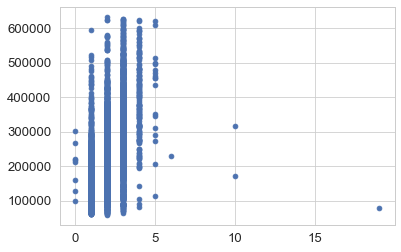

In [82]:

plt.scatter(train_df['Rooms'], train_df['Price'] )


In [83]:
train_df[(train_df['Rooms']<1) | (train_df['Rooms']>6)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.00,59.06,36.22,10.00,22,22.00,2002,0.09,1,1,74,19083,2,900.00,5,15,1,"317,265.32"
12638,27,0.00,138.43,136.22,0.00,4,3.00,2016,0.08,1,1,11,3097,0,900.00,0,0,1,"268,394.74"
8491,1,19.00,42.01,21.78,7.00,17,17.00,2014,0.01,1,1,1,264,0,900.00,0,1,1,"78,364.62"
7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,1,1,9,1892,0,900.00,0,1,1,"302,211.26"
7317,27,0.00,41.79,23.33,0.00,13,0.00,1977,0.21,1,1,9,1892,0,900.00,0,1,1,"98,129.98"
770,28,0.00,49.48,31.02,0.00,16,0.00,2015,0.12,1,1,30,6207,1,"1,183.00",1,0,1,"217,009.34"
456,6,0.00,81.49,63.03,0.00,4,0.00,1977,0.24,1,1,5,1564,0,540.00,0,0,1,"212,864.80"
3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,900.00,0,0,1,"126,596.94"
3159,88,0.00,38.70,19.35,9.00,9,16.00,1982,0.13,1,1,43,8429,3,900.00,3,9,1,"158,998.11"


In [84]:
train_df['Rooms'].mode()[0]

2.0

In [85]:
train_df.loc[(train_df['Rooms']<1) | (train_df['Rooms']>6), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms']<1) | (test_df['Rooms']>6), 'Rooms'] = train_df['Rooms'].mode()[0]

Square

Из своих представлений площадь не должна быть ниже 15 , а верхнюю границу установил 280, по графику

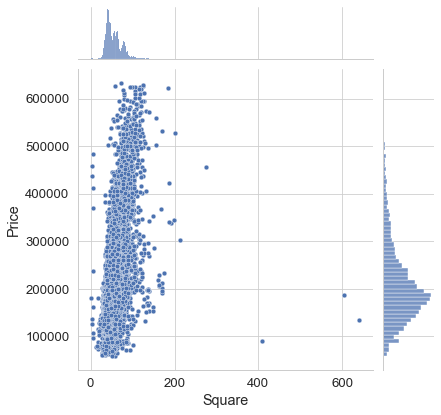

In [86]:
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6)

In [87]:
train_df['Square'].median()

52.51330992401352

In [88]:
train_df.loc[(train_df['Square']<15) , 'Square'] = train_df['Square'].median()
train_df.loc[(train_df['Square']>280), 'Square'] = train_df['Square'] / 10
test_df.loc[(test_df['Square']<15) , 'Square'] = test_df['Square'].median()
test_df.loc[(test_df['Square']>280), 'Square'] = test_df['Square'] / 10

Kitchen Square

значения кухни подобрал эмпирически

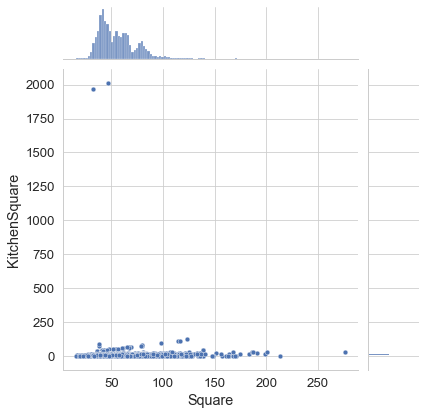

In [89]:

sns.jointplot(train_df['Square'], train_df['KitchenSquare'], kind='scatter', height=6)

In [90]:
len(train_df[(train_df['Square'] < train_df['KitchenSquare'])])

4

In [91]:
train_df['KitchenSquare'].mode()

0   1.00
dtype: float64

In [92]:


train_df.loc[(train_df['KitchenSquare'] > 32) | \
             (train_df['KitchenSquare'] < 2),
             'KitchenSquare'] = train_df['KitchenSquare'].median()

test_df.loc[(test_df['KitchenSquare'] > 32) | \
             (test_df['KitchenSquare'] < 2),
             'KitchenSquare'] = train_df['KitchenSquare'].median()



LifeSquare
Для нахождения воспольовался средним отношением  LifeSquare к Square

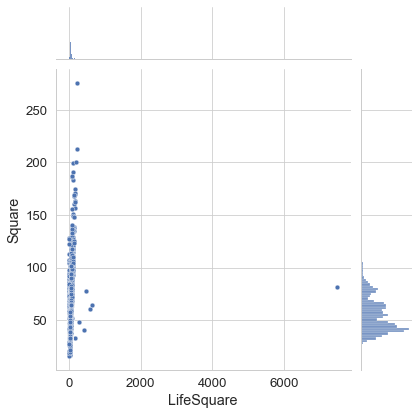

In [93]:
sns.jointplot(train_df['LifeSquare'], train_df['Square'], kind='scatter', height=6)

In [94]:
train_df.loc[(train_df['LifeSquare'] > train_df['Square']) | \
             (train_df['LifeSquare'] < 10),
             'LifeSquare'] = train_df['Square'] - features_Square_LifeSquare.median()

test_df.loc[(test_df['LifeSquare'] > test_df['Square']) | \
             (test_df['LifeSquare'] < 10),
             'LifeSquare'] = test_df['Square'] - features_Square_LifeSquare.median()

HouseFloor, Floor

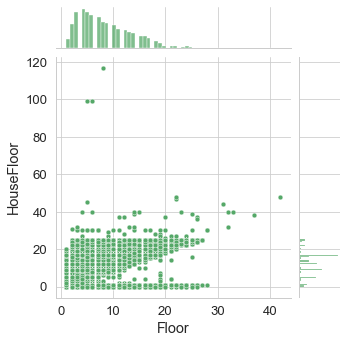

In [95]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=5, color='g')

In [96]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = 1

train_df.loc[train_df['HouseFloor'] > 40, 'HouseFloor'] = 1
test_df.loc[test_df['HouseFloor'] > 40, 'HouseFloor'] = 1

In [97]:
train_df.loc[train_df['Floor'] == 0, 'Floor'] = train_df['Floor'].mode()[0]
test_df.loc[test_df['Floor'] == 0, 'Floor'] = train_df['Floor'].mode()[0]

train_df.loc[train_df['Floor'] > 40, 'Floor'] = train_df['Floor'].mode()[0]
test_df.loc[test_df['Floor'] > 40, 'Floor'] = train_df['Floor'].mode()[0]

In [98]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.23,37.05,7.35,8.52,12.58,"3,990.17",0.12,0.99,0.97,24.69,"5,352.16",8.04,"1,026.36",1.32,4.23,0.92,"214,138.86"
std,43.59,0.81,19.06,17.12,2.30,5.23,6.50,"200,500.26",0.12,0.10,0.16,17.53,"4,006.80",23.83,746.66,1.49,4.81,0.28,"92,872.29"
min,0.00,1.00,16.12,-2.35,2.00,1.00,1.00,"1,910.00",0.00,0.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.79,23.43,6.00,4.00,9.00,"1,974.00",0.02,1.00,1.00,6.00,"1,564.00",0.00,830.00,0.00,1.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,33.27,6.00,7.00,13.00,"1,977.00",0.08,1.00,1.00,25.00,"5,285.00",2.00,900.00,1.00,3.00,1.00,"192,269.64"
75%,75.00,2.00,65.89,45.94,9.00,12.00,17.00,"2,001.00",0.20,1.00,1.00,36.00,"7,227.00",5.00,990.00,2.00,6.00,1.00,"249,135.46"
max,209.00,6.00,275.65,233.95,32.00,37.00,40.00,"20,052,011.00",0.52,1.00,1.00,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,1.00,"633,233.47"


HouseYear

In [99]:
train_df.nlargest(10, 'HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.00,37.27,20.24,9.00,9,12.00,20052011,0.14,1,1,30,6141,10,262.00,3,6,1,"254,084.53"
11607,147,2.00,44.79,28.36,5.00,4,9.00,4968,0.32,1,1,25,4756,16,"2,857.00",5,8,1,"243,028.60"
15051,53,2.00,59.60,44.87,10.00,3,24.00,2020,0.05,1,1,34,7759,0,229.00,1,3,1,"243,114.22"
4345,62,1.00,49.28,30.81,6.00,5,1.00,2020,0.07,1,1,2,629,1,900.00,0,0,0,"135,353.89"
6845,169,3.00,87.37,64.91,12.00,4,24.00,2020,0.18,1,1,18,3594,4,192.00,1,5,1,"295,304.01"
2530,53,2.00,64.23,47.41,13.00,13,24.00,2020,0.05,1,1,34,7759,0,229.00,1,3,1,"283,334.50"
6731,120,2.00,85.09,77.98,10.00,7,10.00,2020,0.34,1,1,27,5664,48,"2,300.00",3,11,1,"536,020.26"
3445,53,1.00,35.67,21.39,8.00,4,24.00,2020,0.05,1,1,34,7759,0,229.00,1,3,1,"170,847.42"
8832,1,3.00,83.26,79.44,6.00,15,21.00,2020,0.01,1,1,1,264,0,900.00,0,1,1,"242,243.09"


In [100]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2011
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2011


In [101]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Scatter3d(
    x = train_df["Square"],
    y = train_df["LifeSquare"],
    z = train_df["KitchenSquare"],
    mode = "markers",
    marker = dict(
        size = 5,
        color = train_df["Price"],
        colorscale = "jet",
        colorbar = dict(thickness = 10),
        line = dict(width = 2, color = "DarksLateGrey" )
    )
)])

fig.update_layout(
    margin = dict(l=0, r=0, b=0, t=0),
    scene = dict(
        xaxis_title="Square",
        yaxis_title="LifeSquare",
        zaxis_title="KitchenSquare"),
    )
fig.show()

### Обработка редких категорий
Объединили районы с малым количеством домов в один район, сильно отличающийся по наванию

In [102]:
disctric_size = train_df["DistrictId"].value_counts().reset_index()\
                .rename(columns = {'index':"DistrictId", "DistrictId" : "DisctricSize"})
disctric_size

,DistrictId,DisctricSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,199,1
201,205,1
202,174,1
203,209,1


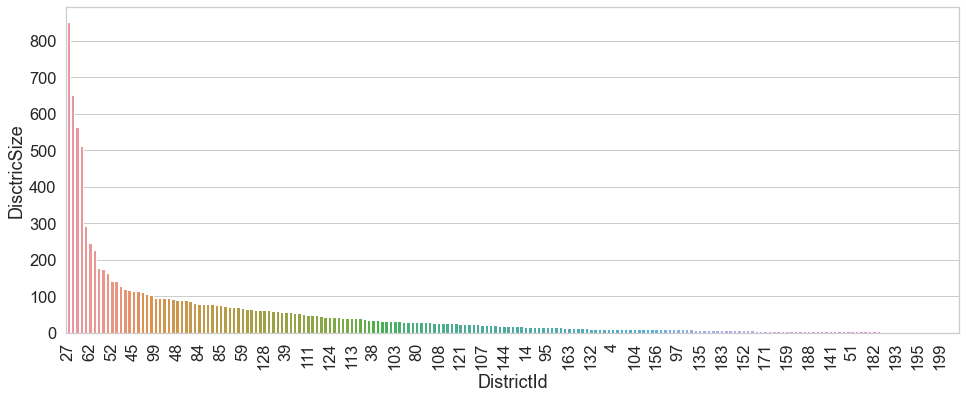

In [103]:
sns.set(style = "whitegrid", font_scale = 1.5)
f, ax = plt.subplots(figsize = (16, 6))
sns.barplot(y = "DisctricSize", x = "DistrictId" ,
           data =disctric_size,
           order = disctric_size.sort_values(by="DisctricSize", ascending = False)["DistrictId"]
           );
ax.tick_params(axis="x", rotation = 90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [104]:
disctric_size.loc[disctric_size["DisctricSize"]> 100, :]

,DistrictId,DisctricSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


In [105]:
Disctrics_popular = disctric_size.loc[disctric_size["DisctricSize"]> 100,"DistrictId"].tolist()

In [106]:
Disctrics_popular

[27, 1, 23, 6, 9, 62, 30, 58, 53, 21, 52, 8, 11, 46, 61, 45, 74, 34, 57, 44]

In [107]:
disctric_size.loc[~ disctric_size["DistrictId"].isin(Disctrics_popular), "DistrictId"] = 999
disctric_size = disctric_size.groupby("DistrictId")["DisctricSize"].agg(DisctricSize="median")
disctric_size.reset_index(level="DistrictId", inplace = True)
disctric_size

,DistrictId,DisctricSize
0,1,652
1,6,511
2,8,142
3,9,294
4,11,129
5,21,165
6,23,565
7,27,851
8,30,228
9,34,111


In [108]:
train_df.loc[~train_df["DistrictId"].isin(Disctrics_popular), "DistrictId"] = 999
test_df.loc[~test_df["DistrictId"].isin(Disctrics_popular), "DistrictId"] = 999


In [109]:
test_df["DistrictId"].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
61       64
8        64
46       61
34       61
74       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

### Построение новых принаков
Построили сильны принаки, на главных принаках

DistrictSize

In [110]:
train_df = train_df.merge(disctric_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(disctric_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DisctricSize
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,1,33,7976,5,900.00,0,11,1,"184,966.93",15
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,1,46,10309,1,240.00,1,16,1,"300,009.45",15
4765,53,2.00,44.95,29.20,6.00,8,12.00,1968,0.05,1,1,34,7759,0,229.00,1,3,1,"220,925.91",174
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"175,616.23",179
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,1,35,5776,1,"2,078.00",2,4,1,"150,226.53",15


PriceOneRoom

In [111]:
train_df["PriceOneRoom"] = train_df["Price"] / train_df['Rooms']

In [112]:
price_by_distric = train_df.groupby(["DistrictId"], as_index=False)\
.agg({'PriceOneRoom': "median"})\
.rename(columns={"PriceOneRoom" : "priceONERoomByDistric"})
price_by_distric

,DistrictId,priceONERoomByDistric
0,1,"106,080.90"
1,6,"94,232.67"
2,8,"120,139.85"
3,9,"96,749.26"
4,11,"100,098.98"
5,21,"104,448.25"
6,23,"76,232.42"
7,27,"94,738.78"
8,30,"93,960.73"
9,34,"129,738.65"


In [113]:
train_df = train_df.merge(price_by_distric, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_distric, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DisctricSize,PriceOneRoom,priceONERoomByDistric
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,...,7976,5,900.00,0,11,1,"184,966.93",15,"92,483.47","129,339.27"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,...,10309,1,240.00,1,16,1,"300,009.45",15,"100,003.15","129,339.27"
4765,53,2.00,44.95,29.20,6.00,8,12.00,1968,0.05,1,...,7759,0,229.00,1,3,1,"220,925.91",174,"110,462.95","138,669.20"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,...,5735,3,"1,084.00",0,5,1,"175,616.23",179,"87,808.11","105,638.52"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,...,5776,1,"2,078.00",2,4,1,"150,226.53",15,"150,226.53","129,339.27"


Стоимость 1 м^2 по району

In [114]:
train_df['PriceSquare'] = train_df['Price'] / train_df['Square']
PriceSquare_by_distric = train_df.groupby(["DistrictId"], as_index=False)\
.agg({'PriceSquare': "median"})\
.rename(columns={"PriceSquare" : "PriceSquarebydistric"})
PriceSquare_by_distric

    

,DistrictId,PriceSquarebydistric
0,1,"3,251.65"
1,6,"2,860.95"
2,8,"4,124.22"
3,9,"3,206.59"
4,11,"4,134.35"
5,21,"3,986.57"
6,23,"2,273.50"
7,27,"2,759.09"
8,30,"2,830.36"
9,34,"4,304.30"


In [115]:
train_df = train_df.merge(PriceSquare_by_distric, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(PriceSquare_by_distric, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DisctricSize,PriceOneRoom,priceONERoomByDistric,PriceSquare,PriceSquarebydistric
Id,,,,,,,,,,,,,,,,,,,,,
14038,999,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,1,...,900.00,0,11,1,"184,966.93",15,"92,483.47","129,339.27","3,854.96","4,491.15"
15053,999,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,1,...,240.00,1,16,1,"300,009.45",15,"100,003.15","129,339.27","4,567.49","4,491.15"
4765,53,2.00,44.95,29.20,6.00,8,12.00,1968,0.05,1,...,229.00,1,3,1,"220,925.91",174,"110,462.95","138,669.20","4,915.15","4,845.92"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,1,...,"1,084.00",0,5,1,"175,616.23",179,"87,808.11","105,638.52","3,291.59","2,949.98"
10783,999,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,1,...,"2,078.00",2,4,1,"150,226.53",15,"150,226.53","129,339.27","3,788.89","4,491.15"


Площадь одной комнаты

In [116]:
train_df['RoomSquare'] = train_df['LifeSquare'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['LifeSquare'] / test_df['Rooms']

### Отбор принаков

Отбор проивели по графику, важности принаков, а так же по коррелиционной таблице

In [117]:
target_name = ['Price']
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#           'Ecology_2',
#            'Ecology_3',
             'Social_1',
           'Social_2',
             'Social_3',
             'Healthcare_1',
             'Helthcare_2',
    "PriceSquarebydistric",
             'Shops_1',
#            'Shops_2',
#             'Price',
    "priceONERoomByDistric",
#            "PriceOneRoom",
            "DisctricSize",
             'RoomSquare',
#           'PriceSquare',
]

Из признаков также уберем признак Social_2, т.к. он сильно кореллирует с Social_1

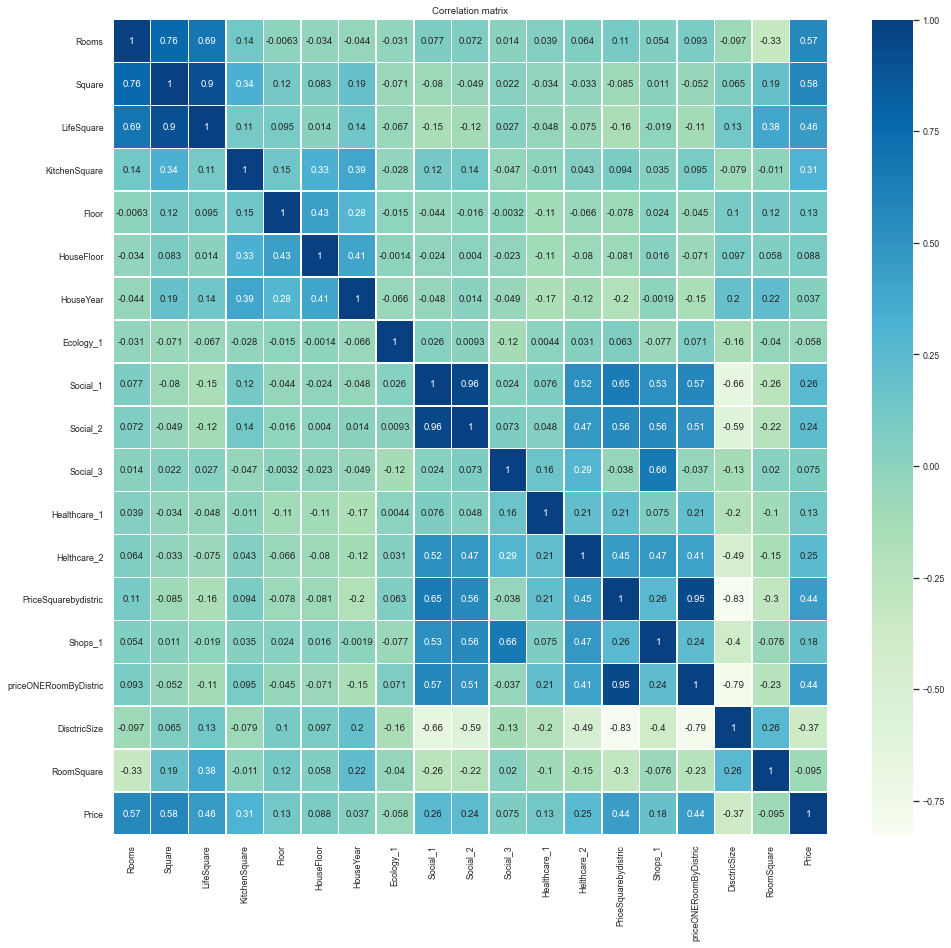

In [118]:
plt.figure(figsize=(16,15))

sns.set(font_scale=0.8)
sns.heatmap(train_df[feature_names + ['Price']].corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Построение модели 
Испробовал две модели для предсказания, Случайный лес сработал хуже GradientBoostingRegressor.
Испольуем стандартижацию, для нормалиации принаков.

In [119]:
feature_names_for_stand = [
             'Rooms',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Social_1',
    "PriceSquarebydistric",
           'Social_2',
             'Social_3',
             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
    "priceONERoomByDistric",
            "DisctricSize",
             'RoomSquare',
]

In [120]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [121]:
X_train_scaled = scaler.fit_transform(train_df[feature_names_for_stand])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_for_stand)

X_test_scaled = scaler.fit_transform(test_df[feature_names_for_stand])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names_for_stand)
X_train_scaled

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,PriceSquarebydistric,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,priceONERoomByDistric,DisctricSize,RoomSquare
0,0.14,-0.43,-0.44,-0.59,-0.29,-0.55,-0.86,-0.25,0.47,0.76,0.65,-0.13,-0.17,-0.88,1.41,0.73,-0.74,-0.74
1,1.37,0.50,0.18,0.28,-0.29,-0.55,-0.37,-1.00,1.22,0.76,1.24,-0.30,-1.05,-0.21,2.45,0.73,-0.74,-0.91
2,0.14,-0.59,-0.46,-0.59,-0.10,-0.09,-0.92,-0.58,0.53,1.19,0.60,-0.34,-1.07,-0.21,-0.26,1.25,-0.18,-0.76
3,0.14,-0.15,0.92,0.72,-0.10,0.68,-0.43,2.68,-0.10,-1.10,0.10,-0.21,0.08,-0.88,0.16,-0.58,-0.16,0.68
4,-1.09,-0.87,-0.78,-0.15,0.47,-0.09,-0.48,-0.89,0.59,0.76,0.11,-0.30,1.41,0.46,-0.05,0.73,-0.74,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.14,-0.31,-0.38,-1.03,-0.48,-1.17,-0.92,0.14,1.22,0.76,0.65,-0.09,-0.91,1.13,1.41,0.73,-0.74,-0.68
9996,-1.09,-0.77,-0.96,0.72,0.86,0.06,0.82,-1.00,0.30,0.76,0.05,-0.34,-0.17,-0.88,0.16,0.73,-0.74,-0.03
9997,-1.09,-0.43,-0.44,-0.59,0.66,0.53,1.64,-0.39,-1.29,-1.33,-1.18,-0.30,-0.17,-0.88,-0.88,-1.18,2.23,1.07
9998,0.14,-0.66,-0.19,0.28,-1.44,-1.17,-1.30,1.58,0.30,0.76,-0.08,0.04,-0.94,0.46,0.16,0.73,-0.74,-0.47


In [122]:
train_df.std()

DistrictId                 486.05
Rooms                        0.81
Square                      19.06
LifeSquare                  17.12
KitchenSquare                2.30
Floor                        5.23
HouseFloor                   6.50
HouseYear                   18.41
Ecology_1                    0.12
Ecology_2                    0.10
Ecology_3                    0.16
Social_1                    17.53
Social_2                 4,006.80
Social_3                    23.83
Healthcare_1               746.66
Helthcare_2                  1.49
Shops_1                      4.81
Shops_2                      0.28
Price                   92,872.29
DisctricSize               281.60
PriceOneRoom            50,731.16
priceONERoomByDistric   18,088.08
PriceSquare              1,251.73
PriceSquarebydistric       828.23
RoomSquare                   8.16
dtype: float64

In [123]:
X = train_df[feature_names]
y = train_df[target_name]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [125]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [126]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

In [127]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.774
Test R2:	0.714


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [129]:
final_model = GradientBoostingRegressor(random_state=42, n_estimators=200, max_depth=5)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [130]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

In [131]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Train R2:	0.909
Test R2:	0.733


## Прогнозирование на тестовом датасете GradientBoostingRegressor

In [132]:
y_test_preds = final_model.predict(test_df[feature_names])

In [133]:
test_df = pd.read_csv("C:/Users/sergey/OneDrive/Рабочий стол/Data Science1/Курсовой проект/test.csv")

In [134]:
result = pd.DataFrame()
result['Id'] = test_df['Id'].copy()
result['Price'] = pd.Series(y_test_preds)

In [135]:
result.to_csv('Сергей Костин_predictions.csv', index=False)
result.values

array([[   725.        , 150970.1946911 ],
       [ 15856.        , 214035.38627109],
       [  5480.        , 176379.92043011],
       ...,
       [  5783.        , 353670.65869271],
       [  4780.        , 198117.4914068 ],
       [ 12504.        , 181476.89572162]])